In [3]:
# initial test and train data

In [17]:
# Basic Matrix Factorization

In [8]:
#import required library
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

In [9]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import warnings

data_df = pd.read_csv('./ratings.dat', sep='::', names=["UserID", "MovieID", "Rating", "Timestamp"], engine='python')

# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1

# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = data_df['UserID'].values
movie_list = data_df['MovieID'].values
for j in range(len(data_df)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
data_df['UserID'] = user_list
data_df['movieID'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(data_df)) <= 0.7
train_df = data_df[train_index]
test_df = data_df[~train_index]

# generate train_mat and test_mat
num_user = len(data_df['UserID'].unique())
num_movie = len(data_df['MovieID'].unique())

train_mat = coo_matrix((train_df['Rating'].values, (train_df['UserID'].values, train_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()
test_mat = coo_matrix((test_df['Rating'].values, (test_df['UserID'].values, test_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()

In [10]:
# Matrix Factorization Model for Explicit Feedback

In [11]:
class MF:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)

        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function

        self.num_user, self.num_movie = train_mat.shape

        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.train_indicator_mat = 1.0 * (train_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in train_mat
        self.test_indicator_mat = 1.0 * (test_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in test_mat

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized

    def train(self, epoch=20, verbose=True):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch
        Output: epoch_loss_list -- a list recording the training loss for each epoch
                epoch_test_RMSE_list -- a list recording the testing RMSE after each training epoch
        """
        epoch_loss_list = []
        epoch_test_RMSE_list = []
        for ep in range(epoch):
            """
            Write your code here to implement the training process for one epoch,
            and at the end of each epoch, print out the epoch number, the training loss after this epoch,
            and the test RMSE after this epoch
            """    
            # shuffle the indices
            shuffled_indices = np.random.permutation(self.num_sample) 
            loss = 0 # initiate loss as 0
            for idx in shuffled_indices:
                u, i = self.sample_user[idx], self.sample_movie[idx]
                error = self.train_mat[u, i] - np.dot(self.P[u], self.Q[i])
                loss += error ** 2
                self.P[u] += self.lr * (error * self.Q[i] - self.reg * self.P[u])
                self.Q[i] += self.lr * (error * self.P[u] - self.reg * self.Q[i])

            epoch_loss = np.sqrt(loss / self.num_sample) # calculate epoch loss
            epoch_loss_list.append(epoch_loss)

            test_pred_mat = np.dot(self.P, self.Q.T)
            test_RMSE = np.sqrt(mean_squared_error(self.test_mat[self.test_mat != 0], test_pred_mat[self.test_mat != 0]))
            epoch_test_RMSE_list.append(test_RMSE)

            if verbose:
                print(f"Epoch {ep + 1}: Training Loss = {epoch_loss}, Test RMSE = {test_RMSE}")


                
            """
            End of your code for this function
            """
        return epoch_loss_list, epoch_test_RMSE_list


    def predict(self):
        prediction_mat = np.matmul(self.P, self.Q.T)
        return prediction_mat

In [12]:
mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)

Epoch 1: Training Loss = 1.143631593683178, Test RMSE = 0.9525459701952682
Epoch 2: Training Loss = 0.9353926982589519, Test RMSE = 0.9367576777356379
Epoch 3: Training Loss = 0.924568405174172, Test RMSE = 0.9334685909091036
Epoch 4: Training Loss = 0.9198975699551454, Test RMSE = 0.9308076269835966
Epoch 5: Training Loss = 0.9159889197150284, Test RMSE = 0.9293898376631591
Epoch 6: Training Loss = 0.9103069900971662, Test RMSE = 0.9249382091625741
Epoch 7: Training Loss = 0.9029669165777833, Test RMSE = 0.9208616511513704
Epoch 8: Training Loss = 0.895099458637337, Test RMSE = 0.9157477355319675
Epoch 9: Training Loss = 0.8876687201586793, Test RMSE = 0.9117584893141861
Epoch 10: Training Loss = 0.8815804246308993, Test RMSE = 0.9091432451784899
Epoch 11: Training Loss = 0.8763581557612846, Test RMSE = 0.906033428882912
Epoch 12: Training Loss = 0.8716852913328921, Test RMSE = 0.9044088624406343
Epoch 13: Training Loss = 0.8680326252495236, Test RMSE = 0.9016304275673133
Epoch 14: Tr

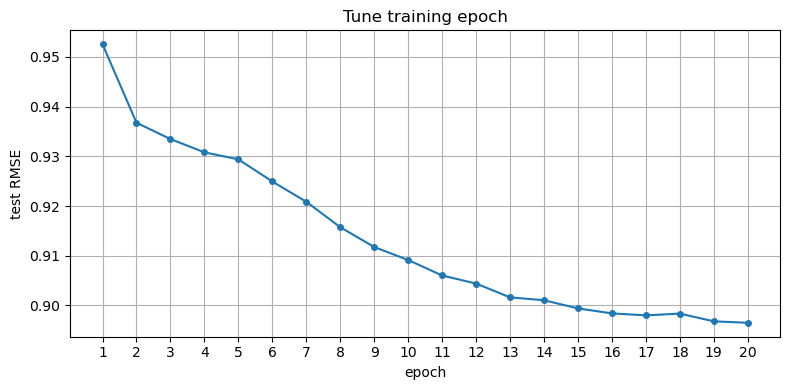

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(np.arange(len(epoch_test_RMSE_list)) + 1, epoch_test_RMSE_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks(np.arange(len(epoch_test_RMSE_list)) + 1)
ax.set_ylabel('test RMSE')
ax.set_xlabel('epoch')
ax.set_title('Tune training epoch')
ax.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# tune latent dimensions

In [15]:
best_epoch = 20 # choosing the one with lowest rmse
best_epoch_test_rmse = []
latent_dim = [1,3,5,7,9]
for i in latent_dim:
    mf = MF(train_mat, test_mat, latent=i, lr=0.01, reg=0.001)
    epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=best_epoch)
    best_epoch_test_rmse.append(epoch_test_RMSE_list[-1])

Epoch 1: Training Loss = 1.53414321469372, Test RMSE = 0.9959101515763101
Epoch 2: Training Loss = 0.9583221942229335, Test RMSE = 0.9471984697248202
Epoch 3: Training Loss = 0.9354221706489588, Test RMSE = 0.9357908496004276
Epoch 4: Training Loss = 0.9295404338740978, Test RMSE = 0.9330426677525842
Epoch 5: Training Loss = 0.9272074302958184, Test RMSE = 0.9318319098622408
Epoch 6: Training Loss = 0.9258627657994032, Test RMSE = 0.9306954001328361
Epoch 7: Training Loss = 0.9253594706828088, Test RMSE = 0.9306157187799814
Epoch 8: Training Loss = 0.9248896897787406, Test RMSE = 0.9295559169101028
Epoch 9: Training Loss = 0.9246769599452822, Test RMSE = 0.9305279436789061
Epoch 10: Training Loss = 0.9245569370008441, Test RMSE = 0.9292581688862718
Epoch 11: Training Loss = 0.9243423469136166, Test RMSE = 0.9304922374609605
Epoch 12: Training Loss = 0.924287689685833, Test RMSE = 0.929582805480771
Epoch 13: Training Loss = 0.9243102258148774, Test RMSE = 0.9293149694390531
Epoch 14: Tr

In [16]:
best_epoch = 20 # choosing the one with lowest rmse (best epoch)
best_latent = 5 # best latent
best_epoch_test_rmse = []
reg = [0.0001,0.0005,0.001,0.0015,0.002]
#reg = [0.0001]
for i in reg:
    mf = MF(train_mat, test_mat, latent=best_latent, lr=0.01, reg=i)
    epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=best_epoch)
    best_epoch_test_rmse.append(epoch_test_RMSE_list[-1])

Epoch 1: Training Loss = 1.1437116718136384, Test RMSE = 0.9536369565921923
Epoch 2: Training Loss = 0.9354385963357854, Test RMSE = 0.9365155583978823
Epoch 3: Training Loss = 0.9246940351544525, Test RMSE = 0.9335776469585831
Epoch 4: Training Loss = 0.9197329220672724, Test RMSE = 0.9307297334333541
Epoch 5: Training Loss = 0.9152424100444746, Test RMSE = 0.9293318015377726
Epoch 6: Training Loss = 0.9090616326028251, Test RMSE = 0.9253742746362207
Epoch 7: Training Loss = 0.9013035563199369, Test RMSE = 0.9199850359078717
Epoch 8: Training Loss = 0.8933747932331756, Test RMSE = 0.9163044695347053
Epoch 9: Training Loss = 0.8865699883320866, Test RMSE = 0.9124111517245697
Epoch 10: Training Loss = 0.8807278140368552, Test RMSE = 0.9086347506982653
Epoch 11: Training Loss = 0.8756049344657771, Test RMSE = 0.9069801635129079
Epoch 12: Training Loss = 0.8712776293697122, Test RMSE = 0.9055246118992992
Epoch 13: Training Loss = 0.867363736136038, Test RMSE = 0.903060545200053
Epoch 14: 

In [18]:
# Matrix Factorization (MF) with bias for both user and movies

In [19]:
#import required library
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

In [20]:
# implemented MF model with user and movie bias
class MF:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.001):
        self.train_mat = train_mat
        self.test_mat = test_mat
        self.latent = latent
        self.lr = lr
        self.reg = reg
        self.num_user, self.num_movie = train_mat.shape
        self.sample_user, self.sample_movie = self.train_mat.nonzero()
        self.num_sample = len(self.sample_user)
        self.train_indicator_mat = 1.0 * (train_mat > 0)
        self.test_indicator_mat = 1.0 * (test_mat > 0)
        self.P = np.random.random((self.num_user, self.latent))
        self.Q = np.random.random((self.num_movie, self.latent))
        self.user_bias = np.random.random(self.num_user)  # initialize user biases
        self.movie_bias = np.random.random(self.num_movie)  # initialize movie biases
    
    # training
    def train(self, epoch=20, verbose=True):
        epoch_loss_list = []
        epoch_test_RMSE_list = []
        for ep in range(epoch):
            shuffled_indices = np.random.permutation(self.num_sample)
            loss = 0
            for idx in shuffled_indices:
                u, i = self.sample_user[idx], self.sample_movie[idx]
                error = self.train_mat[u, i] - (np.dot(self.P[u], self.Q[i]) + self.user_bias[u] + self.movie_bias[i])
                loss += error ** 2
                # update latent factors and biases
                self.P[u] += self.lr * (error * self.Q[i] - self.reg * self.P[u])
                self.Q[i] += self.lr * (error * self.P[u] - self.reg * self.Q[i])
                self.user_bias[u] += self.lr * (error - self.reg * self.user_bias[u])  # update user biases
                self.movie_bias[i] += self.lr * (error - self.reg * self.movie_bias[i]) # update movie biases
            
            # calculate epoch loss
            epoch_loss = np.sqrt(loss / self.num_sample)
            epoch_loss_list.append(epoch_loss)

            test_pred_mat = np.dot(self.P, self.Q.T) + self.user_bias[:, np.newaxis] + self.movie_bias[np.newaxis:,]
            test_RMSE = np.sqrt(mean_squared_error(self.test_mat[self.test_mat != 0], test_pred_mat[self.test_mat != 0]))
            epoch_test_RMSE_list.append(test_RMSE)

            if verbose:
                print(f"Epoch {ep + 1}: Training Loss = {epoch_loss}, Test RMSE = {test_RMSE}")

        return epoch_loss_list, epoch_test_RMSE_list
    
    # prediction 
    def predict(self):
        prediction_mat = np.matmul(self.P, self.Q.T) + self.user_bias[:, np.newaxis] + self.movie_bias[np.newaxis:,]
        return prediction_mat


In [21]:
#run the final code: 
mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=40)

Epoch 1: Training Loss = 1.0150773634788102, Test RMSE = 0.9363060055529594
Epoch 2: Training Loss = 0.9228969056286767, Test RMSE = 0.9269383256090972
Epoch 3: Training Loss = 0.9141334797330409, Test RMSE = 0.9233621882817402
Epoch 4: Training Loss = 0.9092681912497536, Test RMSE = 0.9215776153487211
Epoch 5: Training Loss = 0.9049579419188115, Test RMSE = 0.9210147641572628
Epoch 6: Training Loss = 0.9001032599515687, Test RMSE = 0.9179073638957975
Epoch 7: Training Loss = 0.8940502554422651, Test RMSE = 0.9135112191827954
Epoch 8: Training Loss = 0.8870089785441279, Test RMSE = 0.9105251787393541
Epoch 9: Training Loss = 0.8801612180611136, Test RMSE = 0.9062583709081042
Epoch 10: Training Loss = 0.8736945568615444, Test RMSE = 0.903191418112196
Epoch 11: Training Loss = 0.868157446002054, Test RMSE = 0.9008547955160079
Epoch 12: Training Loss = 0.8631335054399722, Test RMSE = 0.8981555973325058
Epoch 13: Training Loss = 0.8587113761120747, Test RMSE = 0.8966246971761606
Epoch 14: 

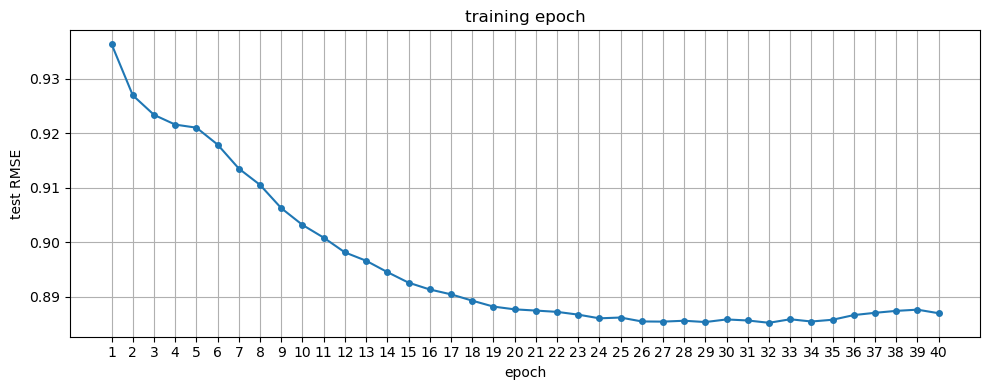

In [22]:
#plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(np.arange(len(epoch_test_RMSE_list)) + 1, epoch_test_RMSE_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks(np.arange(len(epoch_test_RMSE_list)) + 1)
ax.set_ylabel('test RMSE')
ax.set_xlabel('epoch')
ax.set_title('training epoch')
ax.grid(True)
plt.tight_layout()
plt.show()